# Training Neural Networks with PyTorch
Copyright 2021, LEAKY.AI LLC

This exercise is intended for students taking our deep learning course at leaky.ai. In this exercise, we will be training neural networks.

You will:

- Use Google Colab to train simple neural networks
- Explore different loss functions and optimizers
- See how learning rates affect training

To get started, head over to Google Colab via this link:

https://colab.research.google.com

Then load the GitHub project using the following URL:

https://github.com/LeakyAI/PyTorch-Overview

Then replace the <b>[TBD]</b> parts below with your code and execute all the cells.  Most cells will have the correct solution below for you to check your results.
 
Don't forget to have your PyTorch Cheatsheet handy which you can find in the downloads below the class video.

Good luck!

## Import the PyTorch Libraries and Set Random Seeds
Start by importing our PyTorch libraries, setting our random seed to get reproducible results and then verifying our PyTorch version.

In [1]:
# Import PyTorch, NN module and NN.functional as F
# Import matplotlib for our graphs
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math, random
import matplotlib.pyplot as plt

# Set our seed to get reproducible results
torch.manual_seed(6)
random.seed(6)

# Check our PyTorch software version is current
print (f"PyTorch Version: {torch.__version__}")

PyTorch Version: 1.9.0


#### Expected Result:
<pre>PyTorch Version: 1.9.0</pre>

## Create our Dataset
To begin, we will use our Teddy Bear sales data from the previous assingment. 

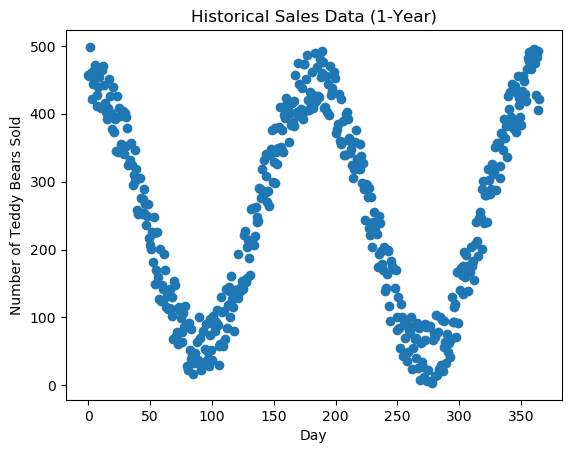

In [2]:
# Create a random synthentic sales dataset for Teddy Bear sales over 1 year
day = torch.linspace(0, 365, 500)
teddyBears = (100*(2*torch.cos(day*4*math.pi/365)+torch.rand(500))+200)

# Display our Teddy Bear sales data for year 1
plt.scatter(day, teddyBears)
plt.xlabel("Day")
plt.ylabel("Number of Teddy Bears Sold")
plt.title("Historical Sales Data (1-Year)")
plt.show()

## Build a Multi-Layer Model to Predict Teddy Bear Sales (Regression)
Here, build a model larger model with:

- 1 input
- 25 as the first hidden layer
- 25 as the second hidden layer
- 25 as the third hidden layer
- 1 output

Use a relu (F.relu) activation function on the result of all hidden layers.  Do not use an activation function on the output as this will be a regression task (predicting the number of teddy bears sold on a given day in the year).

In [3]:
# Build a transformation for each image passed into our network
numHiddenUnits = 25

class MyComplexNetwork(nn.Module):
    
        # Network takes 2 inputs, produces 1 output
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(1,numHiddenUnits)
            self.fc2 = nn.Linear(numHiddenUnits,numHiddenUnits)
            self.fc3 = nn.Linear(numHiddenUnits,numHiddenUnits)
            self.fc4 = nn.Linear(numHiddenUnits,1)
        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc3(x))
            x = self.fc4(x)
            return x

# Create an instance of the model and print out summary
net = MyComplexNetwork()
net

MyComplexNetwork(
  (fc1): Linear(in_features=1, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=25, bias=True)
  (fc4): Linear(in_features=25, out_features=1, bias=True)
)

#### Expected Result:  
<pre>MyComplexNetwork(
  (fc1): Linear(in_features=1, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=25, bias=True)
  (fc4): Linear(in_features=25, out_features=1, bias=True)
)</pre>

In [4]:
# Save the model weights
torch.save(net.state_dict(), 'modelcheckpoint.pth')

## Training Part 1 - Prepare your Labeled Data - Inspect, Clean, Normalize, Standardize
- Most datasets have missing items and/or field so remove those
- Networks train better if inputs are small (~-1..1) so we typically scale the inputs (up or down)
- Min Max Normalization – rescale values to a range of 0..1 using max and min values
- Standardization using Z-Scores – rescale with 0 mean and 1 std. deviation, best if outliers
- Networks train better if the output is not overly large so scale if needed (regression problems)

In [5]:
# Inspect our Dataset
print (f"Teddy Bear Sales")
print (f"Min:  {teddyBears.min():.2f}")
print (f"Max:  {teddyBears.max():.2f}")
print (f"Mean: {teddyBears.mean():.2f}")

print (f"\nDays Range")
print (f"Min:  {day.min():.2f}")
print (f"Max:  {day.max():.2f}")
print (f"Mean: {day.mean():.2f}")


Teddy Bear Sales
Min:  3.57
Max:  498.43
Mean: 252.66

Days Range
Min:  0.00
Max:  365.00
Mean: 182.50


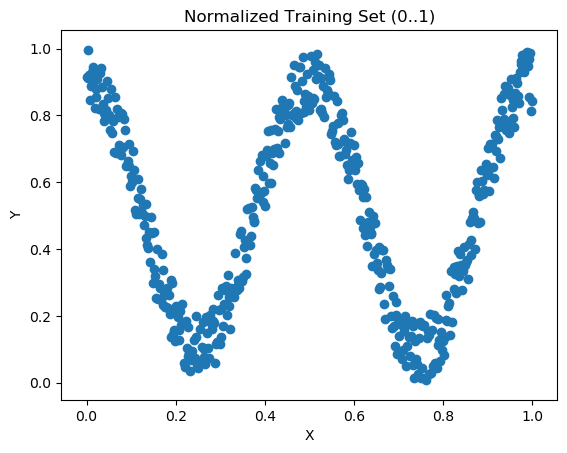

In [6]:
# Create our scale values in order to scale the inputs
# and outputs to be in the range of 0..1
scaleOutput = 500.0     # Teddy Bear Sales should be in range of 0..1
scaleInput = 365.0      # Days (input) should be in the range of [0..1]

# Prepare our normalized training set and add a batch dimension
x=torch.unsqueeze(day/scaleInput, dim=1)
y=torch.unsqueeze(teddyBears/scaleOutput,dim=1)

# Display normalized values for our training data
plt.scatter(x, y)
plt.title("Normalized Training Set (0..1)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show() 

## Training Part 2 - Create Training Code and Display Model
Since we will be training multiple times, we will create a function to train our model and a function to display the model's prediction vs. our training set.

In [7]:
# Train the Neural Network
# Purpose:  This function will train the neural network on the
#           given training dataset for x number of epochs
# Inputs:
#    epochs:     The total number of training epochs
#    model:      The neural network definition
#    x:          Training set input
#    y:          Training set ouput
#    criterion:  Loss function used during training
#    optimizer:  Algorithm for determining weights
def train(epochs, model, x, y, criterion, optimizer):

    model.train()
    
    for epoch in range(epochs):
        y_pred = model(x)    # Single forward pass
        loss = criterion(y_pred, y) # Calculate loss

        optimizer.zero_grad()  # Update the weights
        loss.backward()
        optimizer.step()

        if (epoch % 100 == 0):
            print (f"Loss: {loss:.4f}")

            
# Plot the Model after Training
def displayResults(model,x,scaleInput,scaleOuput,day,teddyBears):
    
    # Print out the Model
    model.eval()
    
    # Make a single forward pass
    pred = net(x)

    # Scale back our output predictions from [0..1] to [0..500]
    predScaled = pred*scaleOuput
    xScaled = x*scaleInput
    
    # Display our model (red) vs our training data
    plt.scatter(day, teddyBears)
    plt.scatter(xScaled.detach().numpy()[:], predScaled.detach().numpy()[:],color="red")
    plt.xlabel("Day")
    plt.ylabel("Teddy Bears")
    plt.show()

## Training Part 3 - Select the Proper Criterion (loss function) and Optimizer
In order to train a neural network, we need a way to measure the loss over each iteration.  We use a loss function (criterion) to measure the output of our model vs. what the actual output we desire.  Depending on the task, you will be using a specific loss function.  In this case, the task is a regression so we will use MSELoss.  For the optimzier (algorithm used to update the weights) we will start with SGD.  Try it with a learning rate of 0.05, mo during training.   SDG with momemtum or Adam are two popular choices.

Loss: 0.6327
Loss: 0.0832
Loss: 0.0817
Loss: 0.0766
Loss: 0.0609


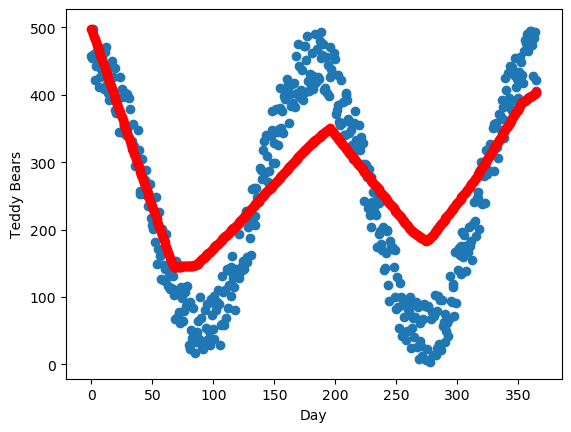

In [11]:
# Reset the model weights to the same as initialized
net.load_state_dict(torch.load('modelcheckpoint.pth'))

# Select our criterion and optimzer
criterion = torch.nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9, nesterov=True)

# Train network and display result
train(500, net, x, y, criterion, optimizer)
displayResults(net,x,scaleInput,scaleOutput,day,teddyBears)

#### Expected Result:  
<pre>Loss: 0.6327
Loss: 0.0832
Loss: 0.0817
Loss: 0.0766
Loss: 0.0609</pre>Note: Your loss values will differ but should decrease with each iteration and end below 0.0700 as in the example above.

## Training Part 4 - Select another Optimizer
The optimzer specifies the algorithm used to update the weights during training.   Sometimes, other optimizers will work better depending on the dataset and model.   Try to change the optimzier to adam with a learning rate of 0.01 and compare the training results with the above.


Loss: 0.6327
Loss: 0.0757
Loss: 0.0236
Loss: 0.0043
Loss: 0.0040


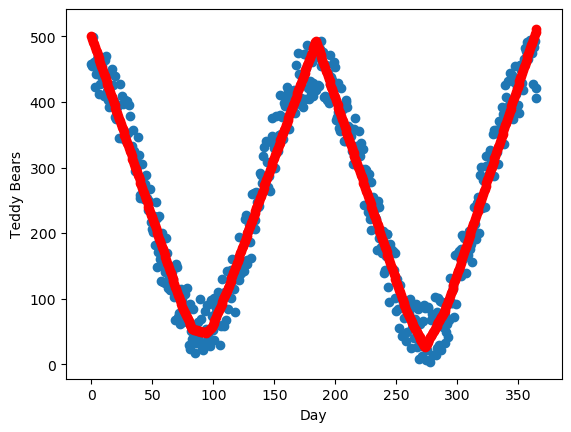

In [13]:
# Reset our weights to their original values
net.load_state_dict(torch.load('modelcheckpoint.pth'))

# Setup your training optimizer and specify your loss criteria
# Start with Adam with a learning rate of 0.01
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# Train network and display result
train(500, net, x, y, criterion, optimizer)
displayResults(net,x,scaleInput,scaleOutput,day,teddyBears)

#### Expected Result:  
<pre>Loss: 0.6327
Loss: 0.0757
Loss: 0.0236
Loss: 0.0043
Loss: 0.0040</pre>Note: Your loss values may differ but should decrease with each iteration and end below 0.0045 as in the example above.

### Next Steps
Try to go back to the training step with SDG and see what modifications to learning rate and epochs could create a better result.  Start by adjusting one slightly, then another and so on.  Are you able to make the predicted (red) curve fit better by adjusting those values?

### Key Takeaways

- You built a PyTorch deep neural network
- You trained the network and compared the ouput with the training set
- You experimented with different optimizers, learning rates and epochs

Congratulations for finishing the second assingment!  

Keep it going!